In [58]:
# STANDARD LIBRARIES
import os
import warnings
warnings.filterwarnings("ignore")

# THIRD PARTY LIBRARIES
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import pydataset
import scipy.stats as stats

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import RFE
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
import sklearn.linear_model
import sklearn.feature_selection
import sklearn.preprocessing


# LOCAL LIBRARIES
import env
import acquire
import prepare

# QUESTIONS / HYPOTHESIS

1. Is square feet of a property a driver of property value while controling for location?
2. Are the number of bedrooms and bathrooms a driver of the value of a property when controlling for square footage?
3. Is the square footage a driver of the value of a property when controllng for bedrooms and bathrooms?
4. Is adding a bedroom more valuable than adding square footage?

- How much does square feet of a property impact the value while controling for location?
- How does the number of bedrooms and bathrooms impact the value of a property when controlling for square footage?
- How does square footage impact the value of a property when controllng for bedrooms and bathrooms?
- Is adding a bedroom more valuable than adding square footage?

==============

- Why do some properties have a much higher value than others when they are located so close to each other? 
- Why are some properties valued so differently from others when they have nearly the same physical attributes but only differ in location? 
- Is having 1 bathroom worse than having 2 bedrooms?

# ACQUIRE

In [2]:
# Acquire data from SQL using module found in acuire.py
df = acquire.get_zillow_data()

Reading from csv file...


In [3]:
df.head()

,bedrooms,bathrooms,square_feet,assessed_value,year_built,tax_amount,state_county_code,county_id
0,4.0,3.5,3100.0,1023282.0,1998.0,11013.72,6059.0,1286.0
1,2.0,1.0,1465.0,464000.0,1967.0,5672.48,6111.0,2061.0
2,3.0,2.0,1243.0,564778.0,1962.0,6488.30,6059.0,1286.0
3,4.0,3.0,2376.0,145143.0,1970.0,1777.51,6037.0,3101.0
4,4.0,3.0,2962.0,773303.0,1950.0,9516.26,6037.0,3101.0


In [4]:
# Obtain rows and column counts
df.shape

(52441, 8)

### Observations/Takeaways

# PREPARE

In [5]:
# acquire 'cleaned' data
df = prepare.wrangle_zillow(df)

In [6]:
df.head()

,bedrooms,bathrooms,square_feet,assessed_value,year_built,tax_amount,state_county_code
0,4.0,3.5,3100.0,1023282.0,1998,11013.72,6059.0
1,2.0,1.0,1465.0,464000.0,1967,5672.48,6111.0
2,3.0,2.0,1243.0,564778.0,1962,6488.30,6059.0
3,4.0,3.0,2376.0,145143.0,1970,1777.51,6037.0
4,4.0,3.0,2962.0,773303.0,1950,9516.26,6037.0


In [7]:
# number of rows and columns after cleaning data
df.shape

(52315, 7)

In [8]:
# review data types and null values
df.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 52315 entries, 0 to 52440
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   bedrooms           52315 non-null  float64
 1   bathrooms          52315 non-null  float64
 2   square_feet        52315 non-null  float64
 3   assessed_value     52315 non-null  float64
 4   year_built         52315 non-null  int64  
 5   tax_amount         52315 non-null  float64
 6   state_county_code  52315 non-null  object 
dtypes: float64(5), int64(1), object(1)
memory usage: 3.2+ MB


In [9]:
# Observe descriptive stats
df.describe().T

,count,mean,std,min,25%,50%,75%,max
bedrooms,52315.0,3.305897,0.940601,0.00,3.000,3.00,4.00,14.0
bathrooms,52315.0,2.302791,1.019080,0.00,2.000,2.00,3.00,18.0
square_feet,52315.0,1922.553914,1003.629061,128.00,1268.000,1658.00,2305.00,21929.0
assessed_value,52315.0,528044.818809,748457.587363,1000.00,193701.000,373374.00,618617.00,49061236.0
year_built,52315.0,1963.395699,23.133908,1878.00,1950.000,1961.00,1979.00,2016.0
tax_amount,52315.0,6434.748320,8709.643614,49.18,2656.185,4645.42,7371.64,586639.3


#### Data Clarification for Location 
(fips_code / state_county_code)

In [10]:
# Identify the unique codes in the state_county_code columns
fips_codes = df.state_county_code.unique()
# sort the values from lowest to highest
fips_codes.sort()
# Obtain the quantity in each location
fips_codes = df.state_county_code.value_counts()
fips_codes

6037.0    33875
6059.0    14082
6111.0     4358
Name: state_county_code, dtype: int64

What are the state_county_codes (fips codes)?
    - Resource: https://www.weather.gov/hnx/cafips
- 2 digit State code
- Followed by 3 digit county code
- 6037 -> Los Angeles
- 6059 -> Orange
- 6111 -> Ventura

In [11]:
# Make categorical column for location based upon the name of the county that belongs to the cooresponding state_county_code (fips code)
df['county_code_bin'] = pd.cut(df.state_county_code, bins=[0, 6037.0, 6059.0, 6111.0], 
                             labels = ['Los Angeles County', 'Orange County',
                             'Ventura County'])
df.head()

,bedrooms,bathrooms,square_feet,assessed_value,year_built,tax_amount,state_county_code,county_code_bin
0,4.0,3.5,3100.0,1023282.0,1998,11013.72,6059.0,Orange County
1,2.0,1.0,1465.0,464000.0,1967,5672.48,6111.0,Ventura County
2,3.0,2.0,1243.0,564778.0,1962,6488.30,6059.0,Orange County
3,4.0,3.0,2376.0,145143.0,1970,1777.51,6037.0,Los Angeles County
4,4.0,3.0,2962.0,773303.0,1950,9516.26,6037.0,Los Angeles County


In [62]:
df['home_sizes'] = pd.cut(df.square_feet, bins=[0, 400, 1500, 2500, 3500, 25000], 
                             labels = ['Tiny', 'Small',
                             'Medium', 'Large', 'Extra-Large'])
df.head()

,bedrooms,bathrooms,square_feet,assessed_value,year_built,tax_amount,state_county_code,county_code_bin,home_sizes,total_rooms
0,4.0,3.5,3100.0,1023282.0,1998,11013.72,6059.0,Orange County,Large,7.5
1,2.0,1.0,1465.0,464000.0,1967,5672.48,6111.0,Ventura County,Small,3.0
2,3.0,2.0,1243.0,564778.0,1962,6488.30,6059.0,Orange County,Small,5.0
3,4.0,3.0,2376.0,145143.0,1970,1777.51,6037.0,Los Angeles County,Medium,7.0
4,4.0,3.0,2962.0,773303.0,1950,9516.26,6037.0,Los Angeles County,Large,7.0


In [13]:
df['total_rooms'] = df['bedrooms'] + df['bathrooms']
df.head()

,bedrooms,bathrooms,square_feet,assessed_value,year_built,tax_amount,state_county_code,county_code_bin,home_sizes,total_rooms
0,4.0,3.5,3100.0,1023282.0,1998,11013.72,6059.0,Orange County,Large,7.5
1,2.0,1.0,1465.0,464000.0,1967,5672.48,6111.0,Ventura County,Small,3.0
2,3.0,2.0,1243.0,564778.0,1962,6488.30,6059.0,Orange County,Small,5.0
3,4.0,3.0,2376.0,145143.0,1970,1777.51,6037.0,Los Angeles County,Average,7.0
4,4.0,3.0,2962.0,773303.0,1950,9516.26,6037.0,Los Angeles County,Large,7.0


#### Observations/Takeaways:

## Univariate Distributions

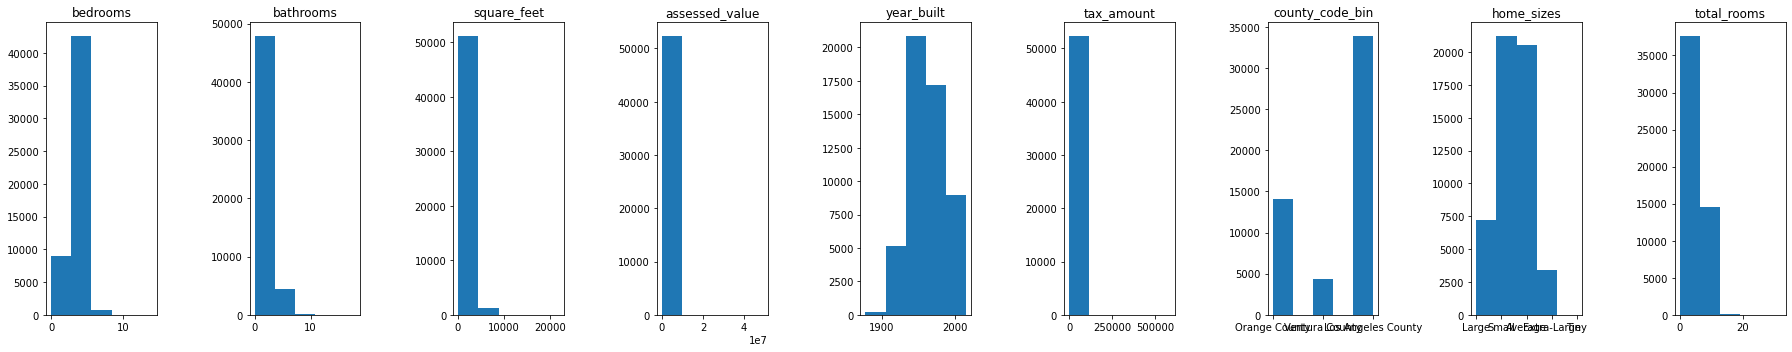

In [14]:
# list of numeric columns
cols = [col for col in df.columns if col not in ['state_county_code']]

# figsize width to height
plt.figure(figsize=(25, 5))

# loop to iterate over columns
for i, col in enumerate(cols):
        
        # i starts at 0 but plot numbers should start at 1
        plot_number = i + 1
        
        # create subplot
        plt.subplot(1, len(cols), plot_number)
        
        # create title with the column name
        plt.title(col)
        
        # display a histogram for each of the columns            
        df[col].hist(bins=5)
        
        # Hide gridlines.
        plt.grid(False)
         
        # turn off scientific notation
        #plt.ticklabel_format(useOffset=False)
    
plt.tight_layout()
plt.show()

bedrooms
bathrooms
square_feet
assessed_value
year_built
tax_amount
state_county_code
total_rooms


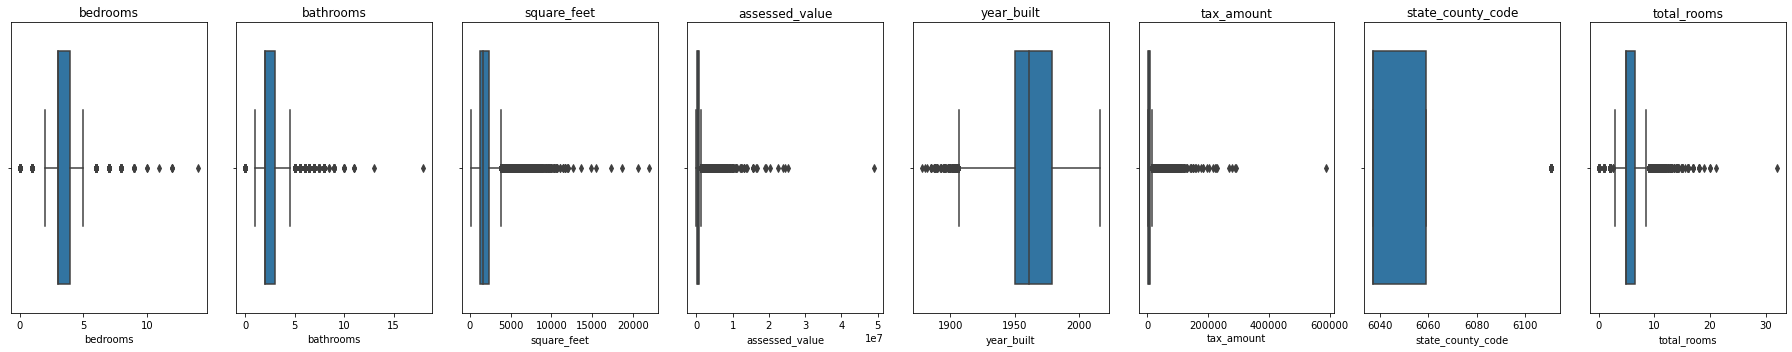

In [15]:
# Visualize Boxplot/Skew


# list of numeric columns
cols = [col for col in df.columns if col not in ['fed_code', 'county_code_bin', 'home_sizes']]

# figsize width to height
plt.figure(figsize=(25, 5))

# loop to iterate over columns
for i, col in enumerate(cols):
        
        # i starts at 0 but plot numbers should start at 1
        plot_number = i + 1
        
        # create subplot
        plt.subplot(1, len(cols), plot_number)
        
        # create title with the column name
        plt.title(col)
        print(col)
        # display a histogram for each of the columns            
        sns.boxplot(x=col, data=df)
        
        # Hide gridlines.
        plt.grid(False)
         
      

plt.tight_layout()
plt.show()


#### Observations / Takeaways

- Bedrooms, bathrooms, square_feet, tax_assessed_value_USD and tax_amount are not very helpful in seeing the spread because they are too narrow in scope. 
- Data is skewed due to outliers 
- Clear outiers in all categories Scales are not helpful
- Better to remove prior to scaling (on TRAIN set only)

### PREPARE - SPLIT THE DATA

Construct an ML Regression model that predict propery tax assessed values ('taxvaluedollarcnt') of Single Family Properties using attributes of the properties.

Find the key drivers of property value for single family properties. Some questions that come to mind are: Why do some properties have a much higher value than others when they are located so close to each other? Why are some properties valued so differently from others when they have nearly the same physical attributes but only differ in location? Is having 1 bathroom worse than having 2 bedrooms?

Deliver a report that the data science team can read through and replicate, understand what steps were taken, why and what the outcome was.

Make recommendations on what works or doesn't work in prediction these homes' values.

In [16]:
def split_data(df):
    train_val, test = train_test_split(df, train_size=0.8,random_state=123)
    train, validate = train_test_split(train_val, train_size=0.7, random_state=123)
    print(f'train -> {train.shape}')
    print(f'validate -> {validate.shape}')
    print(f'test -> {test.shape}')
    
    return train, validate, test

In [17]:
train, validate, test = split_data(df)

train -> (29296, 10)
validate -> (12556, 10)
test -> (10463, 10)


## EXPLORE

In [18]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29296 entries, 42782 to 26292
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   bedrooms           29296 non-null  float64 
 1   bathrooms          29296 non-null  float64 
 2   square_feet        29296 non-null  float64 
 3   assessed_value     29296 non-null  float64 
 4   year_built         29296 non-null  int64   
 5   tax_amount         29296 non-null  float64 
 6   state_county_code  29296 non-null  object  
 7   county_code_bin    29296 non-null  category
 8   home_sizes         29296 non-null  category
 9   total_rooms        29296 non-null  float64 
dtypes: category(2), float64(6), int64(1), object(1)
memory usage: 2.1+ MB


In [19]:
cont_cols = ['bedrooms','bathrooms','square_feet', 'assessed_value', 'tax_amount', 'year_built']

In [20]:
# create a function that takes in a dataframe
def plot_variable_pairs(df):
    # plot the columns in a pairplot
    sns.pairplot(df, kind = 'reg', corner = True, plot_kws={'line_kws':{'color':'red'}})
    plt.show()

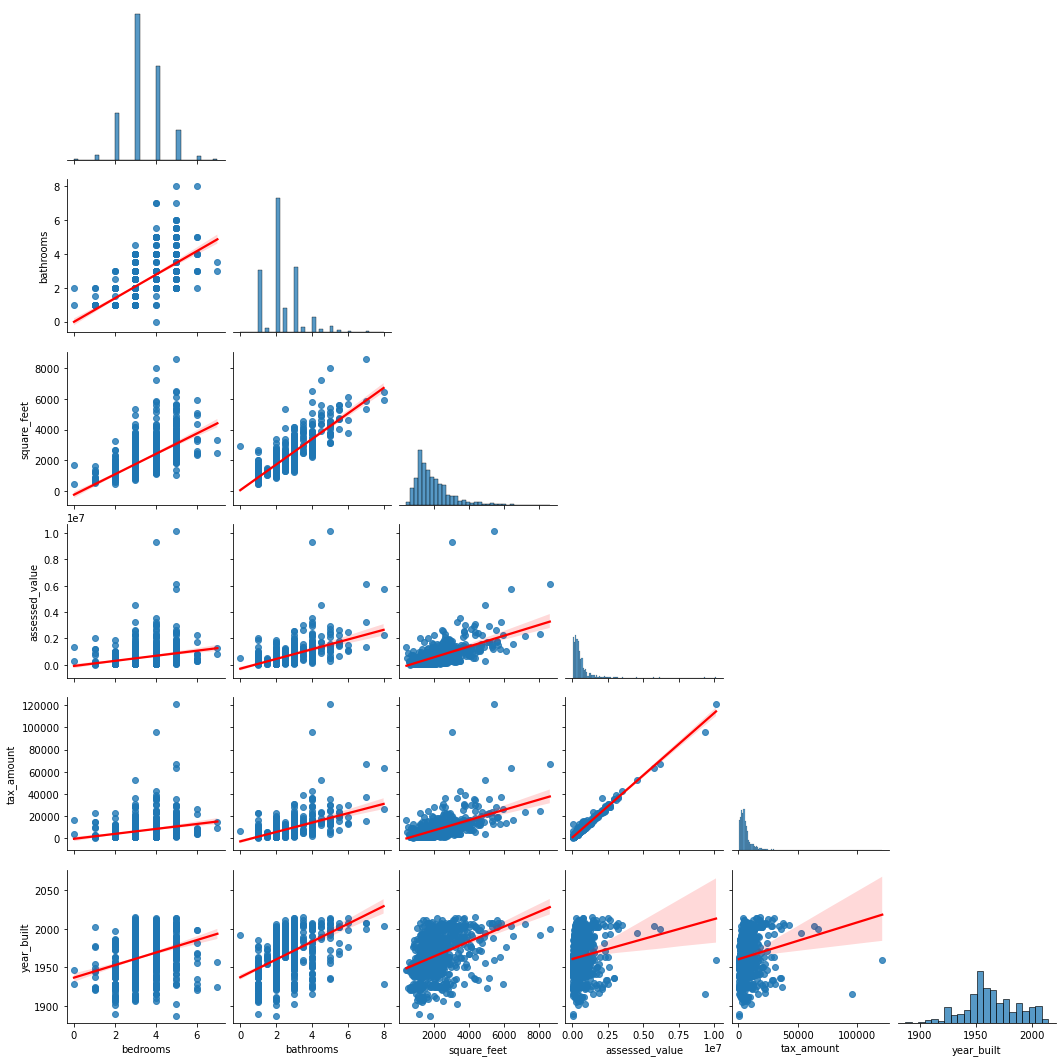

In [21]:
plot_variable_pairs(df[cont_cols].sample(1000))

In [22]:
df_corr = train.corr().reset_index()
corr_matrix = train.corr()
corr_matrix["assessed_value"].sort_values(ascending=False).reset_index().style.background_gradient('coolwarm_r', vmin = -1, vmax = 1)

,index,assessed_value
0,assessed_value,1.000000
1,tax_amount,0.992834
2,square_feet,0.595221
3,bathrooms,0.517639
4,total_rooms,0.443255
5,bedrooms,0.277379
6,year_built,0.167091


In [23]:
# new dataframe that contains properties with 2 bedrooms

# wrote a boolean comparison expression
# used resutls (boolean series) to index into df
# df.column that I wanted to search, set the condition

two_bedrooms = train[train.bedrooms == 2]
two_bedrooms

,bedrooms,bathrooms,square_feet,assessed_value,year_built,tax_amount,state_county_code,county_code_bin,home_sizes,total_rooms
42782,2.0,1.0,614.0,150431.0,1923,2863.70,6037.0,Los Angeles County,Small,3.0
52426,2.0,2.0,856.0,108344.0,1949,1580.48,6037.0,Los Angeles County,Small,4.0
8663,2.0,1.0,1064.0,248230.0,1953,2722.88,6111.0,Ventura County,Small,3.0
35116,2.0,2.0,1814.0,106613.0,1948,1458.82,6037.0,Los Angeles County,Average,4.0
22723,2.0,2.0,1369.0,609177.0,1976,6112.32,6059.0,Orange County,Small,4.0
...,...,...,...,...,...,...,...,...,...,...
4584,2.0,1.0,1164.0,2193267.0,1925,26266.98,6037.0,Los Angeles County,Small,3.0
37388,2.0,1.0,1196.0,230121.0,1951,2842.83,6037.0,Los Angeles County,Small,3.0
32882,2.0,1.0,791.0,390000.0,1948,5028.51,6037.0,Los Angeles County,Small,3.0
37837,2.0,1.0,1160.0,650765.0,1926,7925.40,6037.0,Los Angeles County,Small,3.0


In [24]:
# group_by
# bin - Taking continuous vairbale and breaking it into groups
# aggrigate by location


- raw sq_ft and property footage
Calculate the pearson r statistical test


# mean of property value witha cut-off

t-test avg home value larger in large house in ventura.  VS orange county

In [25]:
- Are the number of bedrooms and bathrooms a driver of the value of a property when controlling for square footage?
- Is the square footage a driver of the value of a property when controllng for bedrooms and bathrooms?

Object `footage` not found.
Object `bathrooms` not found.


In [26]:
Is adding a bedroom more valuable than adding square footage?
#avg home value for bedroom group vs. square footage groups

Object `footage` not found.


### EXPLORATION QUESTIONS

1. Is square feet of a property a driver of property value while controling for location?
2. Are the number of bedrooms and bathrooms a driver of the value of a property when controlling for square footage?
3. Is the square footage a driver of the value of a property when controllng for bedrooms and bathrooms?
4. Is adding a bedroom more valuable than adding square footage?

### QUESTION 1: SQFT & LOCATION
Is square feet of a property a driver of property value while controling for location?

    - Location is categorical
    - Square feet is a continuous vairable.
    - Property value is a continuous variable.

### Hypothesis Testing

#### Visualization

In [112]:
x = train.square_feet
y = train.assessed_value

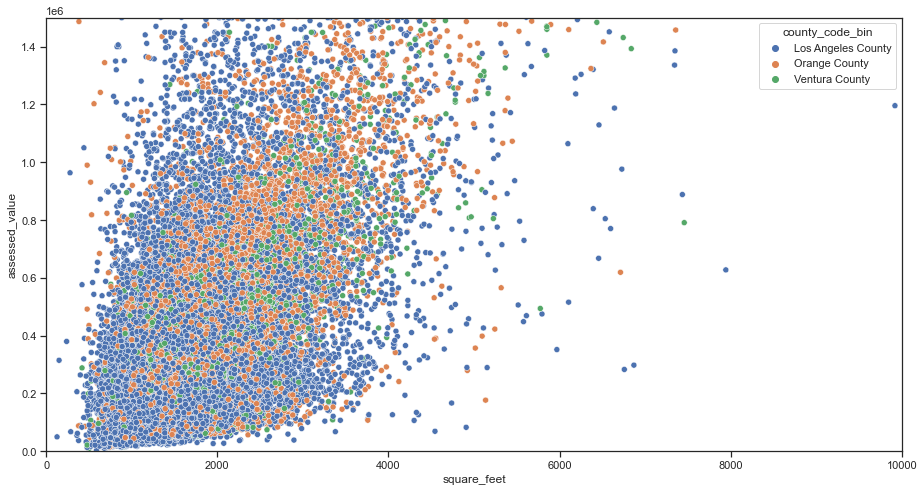

In [72]:
plt.figure(figsize = (13,7))
ax = sns.scatterplot(data=train, x= x, y= y, hue="county_code_bin")

ax.set(xlim = (0, 10000), ylim= (0, 1500000)) # set the limits to the desired ones
plt.tight_layout() # fit labels and legend
plt.show()

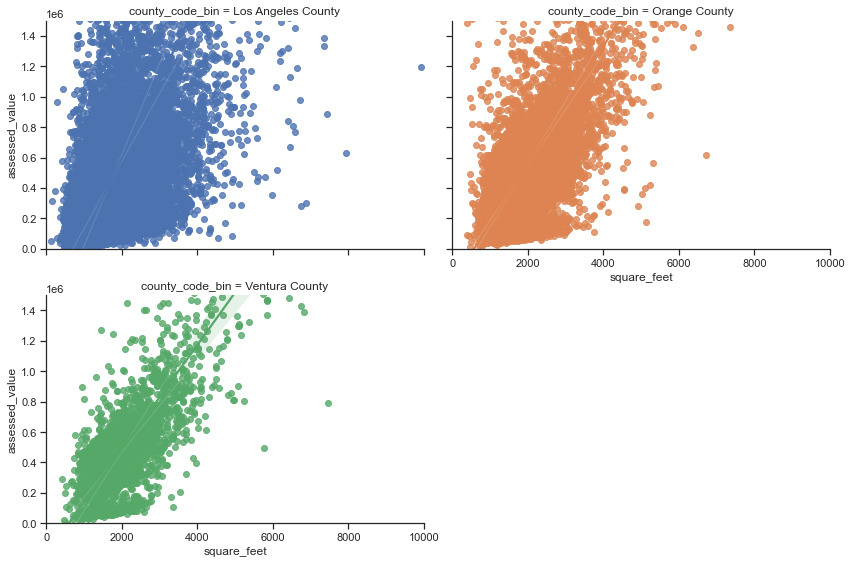

In [71]:
ax = sns.lmplot(x="square_feet", y="assessed_value", col="county_code_bin", hue="county_code_bin",
               data=train, col_wrap=2, height=4, aspect=1.5)

ax.set(xlim = (0, 10000), ylim= (0, 1500000)) # set the limits to the desired ones
plt.tight_layout() # fit labels and legend
plt.show()
# show before and after OR make note that outliers were excluded

#### Data Clarification for Square Feet

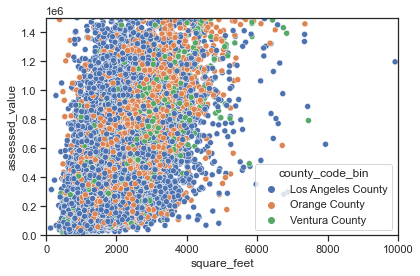

In [81]:
ax=sns.scatterplot(data=train, x="square_feet", y="assessed_value", hue="county_code_bin")

ax.set(xlim = (0, 10000), ylim= (0, 1500000)) # set the limits to the desired ones
plt.tight_layout() # fit labels and legend
plt.show()

#### Hypothesis

In [78]:
# H0 - There is no linear relationship between square footage and assessed value.
# H1 - There is a linear realtionship between square footage and assessed value.

#### Set a Significance Level

In [79]:
α = 0.05

#### Evaluate Assumptions

- Normal: Yes!
- Independent: Yes!
- Variance:

#### Calculate Test Statistic & P-Value

In [80]:
r, p = stats.pearsonr(x,y)
print('r =', r)
print('p =', p)

r = 0.5952206667556583
p = 0.0


- Because p is less than alpha, we reject the null hypothesis that there is no linear correlation between tenure and total charges.    

### QUESTION 1 ANSWER: 

- There is a linear realtionship between square footage and assessed value.

### QUESTION 2: NUMBER of ROOMS & SQUARE FOOTAGE
Are the number of bedrooms and bathrooms a driver of the value of a property when controlling for square footage?

    - Number of rooms is continuous.
    - Square feet is a continuous vairable.
    - Property value is a continuous variable.

### Hypothesis Testing

#### Visualization

In [107]:
x = train.total_rooms
y = train.assessed_value

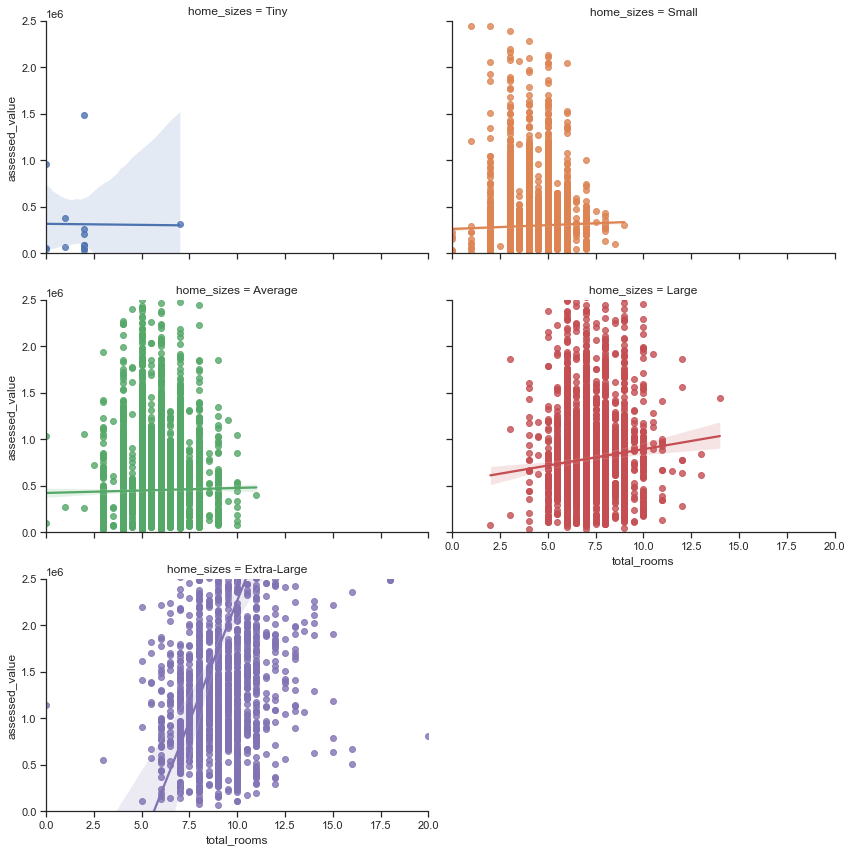

In [108]:
ax = sns.lmplot(x="total_rooms", y="assessed_value", col="home_sizes", hue="home_sizes",
               data=train, col_wrap=2, height=4, aspect=1.5)

ax.set(xlim = (0, 20),ylim= (0, 2500000)) # set the limits to the desired ones
plt.tight_layout() # fit labels and legend
plt.show()
# show before and after OR make note that outliers were excluded

#### Hypothesis

In [109]:
# H0 - There is no linear relationship between number of rooms and assessed value.
# H1 - There is a linear realtionship between number of rooms and assessed value.

#### Set a Significance Level

In [110]:
α = 0.05

#### Evaluate Assumptions

- Normal: Yes!
- Independent: Yes!
- Variance:

#### Calculate Test Statistic & P-Value

In [111]:
r, p = stats.pearsonr(x,y)
print('r =', r)
print('p =', p)

r = 0.44325487517868534
p = 0.0


- Because p is less than alpha, we reject the null hypothesis that there is no linear correlation between tenure and total charges.    

### QUESTION 2 ANSWER: 

- There is a linear realtionship between number of rooms and assessed value.

### QUESTION 3: SQFT & BEDROOMS / BATHROOMS
- Is the square footage a driver of the value of a property when controllng for bedrooms and bathrooms?

### Hypothesis Testing

#### Visualization

In [115]:
x = train.square_feet
y = train.assessed_value

In [ ]:
ax = sns.lmplot(x="square_feet", y="assessed_value", col="bedrooms", hue="bedrooms",
               data=train, col_wrap=2, height=4, aspect=1.5)

ax.set(xlim = (0, 25000), ylim= (0, 1500000)) # set the limits to the desired ones
plt.tight_layout() # fit labels and legend
plt.show()
# show before and after OR make note that outliers were excluded

In [116]:
x = train.square_feet
y = train.assessed_value

In [ ]:
ax = sns.lmplot(x="square_feet", y="assessed_value", col="bathrooms", hue="bathrooms",
               data=train, col_wrap=2, height=4, aspect=1.5)

ax.set(xlim = (0, 25000), ylim= (0, 1500000)) # set the limits to the desired ones
plt.tight_layout() # fit labels and legend
plt.show()
# show before and after OR make note that outliers were excluded

#### Hypothesis

In [ ]:
# H0 - There is no linear relationship between square footage and assessed value.
# H1 - There is a linear realtionship between square footage and assessed value.

#### Set a Significance Level

In [ ]:
α = 0.05

#### Evaluate Assumptions

In [ ]:
- Normal: Yes!
- Independent: Yes!
- Variance:

#### Calculate Test Statistic & P-Value

In [ ]:
r, p = stats.pearsonr(x,y)
print('r =', r)
print('p =', p)

#### Visualization

#### Hypothesis

#### Set a Significance Level

#### Evaluate Assumptions

#### Calculate Test Statistic & P-Value

### Question
- What is the average value of a property based upon the square footage?

In [31]:
df.square_feet.max()

21929.0

(0.0, 10000.0)

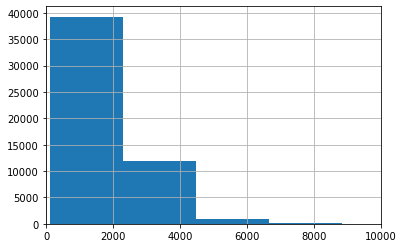

In [32]:
df.head()
df.square_feet.hist()
plt.xlim(0, 10000)

Text(0, 0.5, 'Assessed Value USD')

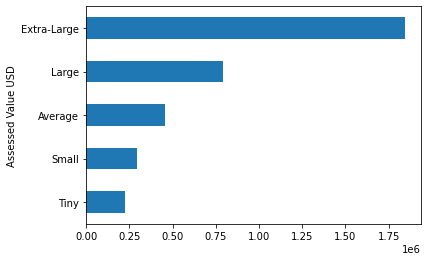

In [33]:
df.groupby('home_sizes').assessed_value.mean().plot.barh()
plt.ylabel('Assessed Value USD')

### Question
- What is the average value of a property based upon the number of bedrooms?

In [34]:
T-TEST homes comparing means of homes with a certain number vs another number of bedrooms

SyntaxError: invalid syntax (4062213981.py, line 1)

In [ ]:
df.groupby('bedrooms').assessed_value.agg(['min', 'mean', 'max'])

In [ ]:
# Engineer feature to combine vs either independently

In [ ]:
df.groupby(['bedrooms', 'bathrooms']).assessed_value.agg(['min', 'mean', 'max'])

In [ ]:
'''
# Create a Graph (countplot) to show data
plt.figure(figsize=(14,7))
 
# count plot on two categorical variable
sns.countplot(x ='internet_service_type', hue = "tax_value", data = train)

plt.title('Customer Churn by Internet Type', fontsize = 20)
plt.xlabel('Internet Type', fontsize = 16)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.ylabel('# of Customers', fontsize = 16)

# Show the plot
plt.show()

'''

### EXPLORATION: Questions

Question 1: Do number of bathrooms impact tax value?

In [ ]:
def visual(df, cont_col, cat_col):

    return sns.swarmplot(x=cat_col, y=cont_col, data=df)
    

In [ ]:
# visual(train, 'tax_value', 'bedrooms')

#### EXPLORATION: Hypothesis Testing

## MODELING & EVALUATION

### Feature Engineering: K-Best

In [ ]:
target = "tax_value"

# split train into X (dataframe, drop target) & y (series, keep target only)
X_train = train.drop(columns=[target])
y_train = train[target]

# split validate into X (dataframe, drop target) & y (series, keep target only)
X_validate = validate.drop(columns=[target])
y_validate = validate[target]

# split test into X (dataframe, drop target) & y (series, keep target only)
X_test = test.drop(columns=[target])
y_test = test[target]

X_train.head()

In [ ]:
X_train.shape

### Baseline

In [ ]:
# establish a baseline for predicted tax value using median which is common for housing values
y_train['baseline'] = train.tax_value.median()
y_validate['baseline'] = train.tax_value.median()

In [ ]:
from sklearn.feature_selection import SelectKBest, f_regression

In [ ]:
type(X_train)

In [ ]:

# Make the filter
kbest = SelectKBest(f_regression, k=3)

# Fit the filter
kbest.fit(X_train.drop(columns = 'tax_amount'), y_train)

# Obtain results as a dataframe
kbest_results = pd.DataFrame(dict(p=kbest.pvalues_, f=kbest.scores_), index=X_train.drop(columns = 'tax_amount').columns)
kbest_results


In [ ]:
X_train.drop(columns = 'tax_amount').columns

In [ ]:
X_train_original = X_train.copy()
X_train = X_train.drop(columns='tax_amount')

In [ ]:
X_train_transformed = pd.DataFrame(
    kbest.transform(X_train),
    index=X_train.index,
    columns=X_train.columns[kbest.get_support()]
)
X_train_transformed.head().sort_index()

### Feature Engineering: RFE

In [ ]:
def scaled_data(X_train, X_validate, X_test, continuous_cols):

    scaler = sklearn.preprocessing.MinMaxScaler()

    # Fit the scaler, (fit the thing)
    scaler.fit(X_train[continuous_cols])

    # Use the scaler to transform train, validate, test (use the thing) and make them into dataframes
    X_train_scaled = pd.DataFrame(scaler.transform(X_train[continuous_cols]), index=X_train.index, columns=X_train[continuous_cols].columns)
    X_validate_scaled = pd.DataFrame(scaler.transform(X_validate[continuous_cols]), index=X_validate.index, columns=X_validate[continuous_cols].columns)
    X_test_scaled = pd.DataFrame(scaler.transform(X_test[continuous_cols]), index=X_test.index, columns=X_test[continuous_cols].columns)
                                        
                                        
    
    return X_train_scaled, X_validate_scaled, X_test_scaled 

In [ ]:
X_train.shape, X_validate.shape, X_test.shape

In [ ]:
X_train_scaled, X_validate_scaled, X_test_scaled = scaled_data(X_train, X_validate, X_test,['bedrooms','bathrooms','square_feet', 'year_built'])


In [ ]:
X_train_scaled.head()

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE

In [ ]:
model = LinearRegression()
# Make the thing
rfe = RFE(model, n_features_to_select=2)
# Fit the thing
rfe.fit(X_train, y_train)
# Obtain results in dataframe
pd.DataFrame({'rfe_ranking': rfe.ranking_}, index=X_train.columns).sort_values(by = 'rfe_ranking')

In [ ]:
X_train.columns[rfe.get_support()]

## SIMPLE MODEL

In [ ]:
predictions = pd.DataFrame({
    'actual': validate.tax_value
}) 

In [ ]:
predictions.head()

In [ ]:
from sklearn.linear_model import LinearRegression

# X must be 2-d
X_train = train[['bathrooms']]
# y can be 1-d
y_train = train.tax_value

# 1. make the thing
lm = LinearRegression()
# 2. fit the thing
lm.fit(X_train, y_train)
# 3. use the thing (make predictions)
X_validate = validate[['bathrooms']]
predictions['simple_lm'] = lm.predict(X_validate)

In [ ]:
predictions.head()

In [ ]:
lm.coef_, lm.intercept_

In [ ]:
print('tax_value = {:.3f} * bathrooms + {:.3f}'.format(lm.coef_[0], lm.intercept_))

In [ ]:
x_pred = np.array([0, 10]).reshape(-1, 1)
y_pred = lm.predict(x_pred)

plt.figure(figsize=(16, 9))
plt.scatter(train.bathrooms, train.tax_value, label='actual')
plt.scatter(train.bathrooms, lm.predict(train[['bathrooms']]), label='simple_lm')
plt.plot(x_pred, y_pred, ls='--', c='black', label='linear model prediction line')


plt.xlabel('Bathrooms')
plt.ylabel('Tax Value')
plt.legend()

In [ ]:
Turn continuous into categorical example houses greater than or less than (square feet).